# Performance Analysis Project

Work by: Gonçalo Dias and Vicente Bandeira

## Introduction

This notebook serves as both an implementation and a report for the work proposed to us in the CDLE cadeira in IACD. In this report, we present the findings of our comprehensive analysis of machine learning performance using various Python libraries for big data processing. As the scale and complexity of data continue to grow, the choice of tools and libraries becomes critical in ensuring efficient and effective machine learning workflows. To address this, we executed a full Machine Learning Pipeline using several prominent big data libraries: PySpark, Dask, Modin, JobLib, Rapids and Koalas

## EXPERIMENT 1: Repeating the NYC taxi driver dataset study

Source: https://www.databricks.com/blog/2021/04/07/benchmark-koalas-pyspark-and-dask.html

In [31]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [32]:
import databricks.koalas as ks
import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import pandas as pd
import numpy as np
import time
import yaml
import matplotlib.pyplot as plt

print('pandas version: %s' % pd.__version__)
print('numpy version: %s' % np.__version__)
print('koalas version: %s' % ks.__version__)
print('dask version: %s' % dask.__version__)

pandas version: 1.1.5
numpy version: 1.19.5
koalas version: 1.7.0
dask version: 2021.04.1


### Dataset information

In [3]:
url = "../yellow_tripdata_2011-01.parquet"
koalas_data = ks.read_parquet(url)

In [4]:
print("Number of rows:", len(koalas_data))
print()
print(koalas_data.head(10))

Number of rows: 13464997

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  airport_fee
0         2  2011-01-01 00:10:00   2011-01-01 00:12:00                4            0.0           1               None           145           145             1          2.9    0.5      0.5        0.28           0.0                    0.0          4.18                   NaN          NaN
1         2  2011-01-01 00:04:00   2011-01-01 00:13:00                4            0.0           1               None           264           264             1          5.7    0.5      0.5        0.24           0.0                    0.0          6.94                   NaN          NaN
2         2  2011-01-01 00:14:00   2011-01-01 00:16:00                4            0.0           1               

In [5]:
koalas_data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [6]:
expr_filter = (koalas_data['tip_amount'] >= 1) & (koalas_data['tip_amount'] <= 5)
 
print(f'Filtered data is {len(koalas_data[expr_filter]) / len(koalas_data) * 100}% of total data')

Filtered data is 35.84216914418919% of total data


### Experiment preparation

In [33]:
def benchmark(f, df, benchmarks, name, **kwargs):
    """Benchmark the given function against the given DataFrame.

    Parameters
    ----------
    f: function to benchmark
    df: data frame
    benchmarks: container for benchmark results
    name: task name


    Returns
    -------
    Duration (in seconds) of the given operation
    """

    start_time = time.monotonic()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.monotonic() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")

def get_results(benchmarks):
    """Return a pandas DataFrame containing benchmark results."""
    return pd.DataFrame.from_dict(benchmarks)

In [34]:
paths = ["../yellow_tripdata_201"+str(i)+"-01.parquet" for i in range(1,4)]

## Koalas

In this section we utilized the Koalas library for our experiments, trying it on Standard operations, operations with filtering and operations with filtering and caching.

In [35]:
koalas_data = ks.read_parquet(paths[0])

In [36]:
koalas_benchmarks = {
    'duration': [],     # in seconds
    'task': []
}

#### Standard operations

In [37]:
def read_file_parquet(df=None):
    return ks.read_parquet("../yellow_tripdata_2011-01.parquet")

def count(df=None):
    return len(df)

def count_index_length(df=None):
    return len(df.index)

def mean(df):
    return df.fare_amount.mean()

def standard_deviation(df):
    return df.fare_amount.std()

def mean_of_sum(df):
    return (df.fare_amount + df.tip_amount).mean()

def sum_columns(df):
    x = df.fare_amount + df.tip_amount
    return x

def mean_of_product(df):
    return (df.fare_amount * df.tip_amount).mean()

def product_columns(df):
    x = df.fare_amount * df.tip_amount
    return x

def value_counts(df):
    val_counts = df.fare_amount.value_counts()
    return val_counts


#   In the original experiment, the following two functions used the longitude and latitude values of the pickup and the dropout places.
#   Since the datasets provided by NYC TLC Trip Record Data no longer have longitude and latitude values (only the pickup and dropout places IDs),
# we used arbitrary longitude and latitude values. The goal of this experiment is to compare the computational cost of the calculations, hence
# the values are not relevant.
def complicated_arithmetic_operation(df):
    start_lon,end_lon = np.random.randint(-180,180),np.random.randint(-180,180)
    start_lat,end_lat = np.random.randint(-90,90),np.random.randint(-90,90)
    
    theta_1 = start_lon
    phi_1 = start_lat
    theta_2 = end_lon
    phi_2 = end_lat
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180) * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = np.multiply(np.arctan2(np.sqrt(temp), np.sqrt(1-temp)),2)
    return ret

def mean_of_complicated_arithmetic_operation(df):
    start_lon,end_lon = np.random.randint(-180,180),np.random.randint(-180,180)
    start_lat,end_lat = np.random.randint(-90,90),np.random.randint(-90,90)
    
    theta_1 = start_lon
    phi_1 = start_lat
    theta_2 = end_lon
    phi_2 = end_lat
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180) * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = np.multiply(np.arctan2(np.sqrt(temp), np.sqrt(1-temp)),2) 
    return ret.mean()

def groupby_statistics(df):
    gb = df.groupby(by='passenger_count').agg(
      {
        'fare_amount': ['mean', 'std'], 
        'tip_amount': ['mean', 'std']
      }
    )
    return gb

other = ks.DataFrame(groupby_statistics(koalas_data).to_pandas())
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

def join_count(df, other):
    return len(df.merge(other.spark.hint("broadcast"), left_index=True, right_index=True))

def join_data(df, other):
    ret = df.merge(other.spark.hint("broadcast"), left_index=True, right_index=True)
    return ret

In [38]:
benchmark(read_file_parquet, df=None, benchmarks=koalas_benchmarks, name='read file')
benchmark(count, df=koalas_data, benchmarks=koalas_benchmarks, name='count')
benchmark(count_index_length, df=koalas_data, benchmarks=koalas_benchmarks, name='count index length')
benchmark(mean, df=koalas_data, benchmarks=koalas_benchmarks, name='mean')
benchmark(standard_deviation, df=koalas_data, benchmarks=koalas_benchmarks, name='standard deviation')
benchmark(mean_of_sum, df=koalas_data, benchmarks=koalas_benchmarks, name='mean of columns addition')
benchmark(sum_columns, df=koalas_data, benchmarks=koalas_benchmarks, name='addition of columns')
benchmark(mean_of_product, df=koalas_data, benchmarks=koalas_benchmarks, name='mean of columns multiplication')
benchmark(product_columns, df=koalas_data, benchmarks=koalas_benchmarks, name='multiplication of columns')
benchmark(value_counts, df=koalas_data, benchmarks=koalas_benchmarks, name='value counts')
benchmark(complicated_arithmetic_operation, df=koalas_data, benchmarks=koalas_benchmarks, name='complex arithmetic ops')
benchmark(mean_of_complicated_arithmetic_operation, df=koalas_data, benchmarks=koalas_benchmarks, name='mean of complex arithmetic ops')
benchmark(groupby_statistics, df=koalas_data, benchmarks=koalas_benchmarks, name='groupby statistics')
benchmark(join_count, koalas_data, benchmarks=koalas_benchmarks, name='join count', other=other)
benchmark(join_data, koalas_data, benchmarks=koalas_benchmarks, name='join', other=other)

read file took: 0.25 seconds
count took: 0.20400000002700835 seconds
count index length took: 0.125 seconds
mean took: 0.3119999999762513 seconds
standard deviation took: 0.4220000000204891 seconds
mean of columns addition took: 0.6869999999762513 seconds
addition of columns took: 0.03200000000651926 seconds
mean of columns multiplication took: 0.6720000000204891 seconds
multiplication of columns took: 0.031000000017229468 seconds
value counts took: 0.061999999976251274 seconds
complex arithmetic ops took: 0.0 seconds
mean of complex arithmetic ops took: 0.0 seconds
groupby statistics took: 0.125 seconds
join count took: 21.32799999997951 seconds
join took: 0.4850000000442378 seconds


#### Operations with filtering

In [39]:
expr_filter = (koalas_data.tip_amount >= 1) & (koalas_data.tip_amount <= 5)

def filter_data(df):
    return df[expr_filter]

koalas_filtered = filter_data(koalas_data)

In [40]:
benchmark(count, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered count')
benchmark(count_index_length, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered count index length')
benchmark(mean, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered mean')
benchmark(standard_deviation, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered standard deviation')
benchmark(mean_of_sum, koalas_filtered, benchmarks=koalas_benchmarks, name ='filtered mean of columns addition')
benchmark(sum_columns, df=koalas_filtered, benchmarks=koalas_benchmarks, name='filtered addition of columns')
benchmark(mean_of_product, koalas_filtered, benchmarks=koalas_benchmarks, name ='filtered mean of columns multiplication')
benchmark(product_columns, df=koalas_filtered, benchmarks=koalas_benchmarks, name='filtered multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered complex arithmetic ops')
benchmark(value_counts, koalas_filtered, benchmarks=koalas_benchmarks, name ='filtered value counts')
benchmark(groupby_statistics, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered groupby statistics')

other = ks.DataFrame(groupby_statistics(koalas_filtered).to_pandas())
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

benchmark(join_data, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered join', other=other)
benchmark(join_count, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered join count', other=other)

filtered count took: 1.125 seconds
filtered count index length took: 1.375 seconds
filtered mean took: 0.7820000000065193 seconds
filtered standard deviation took: 0.875 seconds
filtered mean of columns addition took: 0.7339999999967404 seconds
filtered addition of columns took: 0.01600000000325963 seconds
filtered mean of columns multiplication took: 0.7959999999729916 seconds
filtered multiplication of columns took: 0.01600000000325963 seconds
filtered mean of complex arithmetic ops took: 0.0 seconds
filtered complex arithmetic ops took: 0.0 seconds
filtered value counts took: 0.0470000000204891 seconds
filtered groupby statistics took: 0.14100000000325963 seconds
filtered join took: 0.5 seconds
filtered join count took: 9.28100000001723 seconds


#### Operations with filtering and caching

In [41]:
koalas_filtered_cached = koalas_filtered.spark.cache()
print(f'Enforce caching: {len(koalas_filtered_cached)} rows of filtered data')

Enforce caching: 4826147 rows of filtered data


In [42]:
benchmark(count, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached count')
benchmark(count_index_length, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached count index length')
benchmark(mean, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached mean')
benchmark(standard_deviation, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached standard deviation')
benchmark(mean_of_sum, koalas_filtered, benchmarks=koalas_benchmarks, name ='filtered and cached mean of columns addition')
benchmark(sum_columns, df=koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached addition of columns')
benchmark(mean_of_product, koalas_filtered, benchmarks=koalas_benchmarks, name ='filtered and cached mean of columns multiplication')
benchmark(product_columns, df=koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached complex arithmetic ops')
benchmark(value_counts, koalas_filtered, benchmarks=koalas_benchmarks, name ='filtered and cached value counts')
benchmark(groupby_statistics, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached groupby statistics')

other = ks.DataFrame(groupby_statistics(koalas_filtered).to_pandas())
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

benchmark(join_data, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached join', other=other)
benchmark(join_count, koalas_filtered, benchmarks=koalas_benchmarks, name='filtered and cached join count', other=other)

filtered and cached count took: 0.8900000000139698 seconds
filtered and cached count index length took: 0.875 seconds
filtered and cached mean took: 0.9529999999795109 seconds
filtered and cached standard deviation took: 0.9690000000409782 seconds
filtered and cached mean of columns addition took: 1.1089999999967404 seconds
filtered and cached addition of columns took: 0.01600000000325963 seconds
filtered and cached mean of columns multiplication took: 1.1559999999590218 seconds
filtered and cached multiplication of columns took: 0.031000000017229468 seconds
filtered and cached mean of complex arithmetic ops took: 0.0 seconds
filtered and cached complex arithmetic ops took: 0.0 seconds
filtered and cached value counts took: 0.06300000002374873 seconds
filtered and cached groupby statistics took: 0.10899999999674037 seconds
filtered and cached join took: 0.46799999999348074 seconds
filtered and cached join count took: 8.65700000000652 seconds


# Dask

We repeated this experiment with Dask, on the same 3 sets of operations: standard, with filtering and with filtering and caching.

In [ ]:
cluster = LocalCluster(memory_limit='8GB')
client = Client(cluster)

dask_data = dd.read_parquet(paths[0])

In [48]:
dask_benchmarks = {
    'duration': [],  # in seconds
    'task': [],
}

#### Standard operations

In [49]:
def read_file_parquet(df=None):
    return dd.read_parquet("../yellow_tripdata_2011-01.parquet")

def count(df=None):
    return len(df)

def count_index_length(df=None):
    return len(df.index)

def mean(df):
    return df.fare_amount.mean().compute()

def standard_deviation(df):
    return df.fare_amount.std().compute()

def mean_of_sum(df):
    return (df.fare_amount + df.tip_amount).mean().compute()

def sum_columns(df):
    return (df.fare_amount + df.tip_amount).compute()

def mean_of_product(df):
    return (df.fare_amount * df.tip_amount).mean().compute()

def product_columns(df):
    return (df.fare_amount * df.tip_amount).compute()

def value_counts(df):
    return df.fare_amount.value_counts().compute()

#   In the original experiment, the following two functions used the longitude and latitude values of the pickup and the dropout places.
#   Since the datasets provided by NYC TLC Trip Record Data no longer have longitude and latitude values (only the pickup and dropout places IDs),
# we used arbitrary longitude and latitude values. The goal of this experiment is to compare the computational cost of the calculations, hence
# the values are not relevant.
def mean_of_complicated_arithmetic_operation(df):
    start_lon,end_lon = np.random.randint(-180,180),np.random.randint(-180,180)
    start_lat,end_lat = np.random.randint(-90,90),np.random.randint(-90,90)
    theta_1 = start_lon
    phi_1 = start_lat
    theta_2 = end_lon
    phi_2 = end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret.mean()

def complicated_arithmetic_operation(df):
    start_lon,end_lon = np.random.randint(-180,180),np.random.randint(-180,180)
    start_lat,end_lat = np.random.randint(-90,90),np.random.randint(-90,90)
    theta_1 = start_lon
    phi_1 = start_lat
    theta_2 = end_lon
    phi_2 = end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg({
        'fare_amount': ['mean', 'std'],
        'tip_amount': ['mean', 'std'] 
    })

other = groupby_statistics(dask_data)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

def join_count(df, other):
    return len(dd.merge(df, other, left_index=True, right_index=True))

def join_data(df, other):
    return dd.merge(df, other, left_index=True, right_index=True).compute()

In [50]:
benchmark(read_file_parquet, df=None, benchmarks=dask_benchmarks, name='read file')
benchmark(count, df=dask_data, benchmarks=dask_benchmarks, name='count')
benchmark(count_index_length, df=dask_data, benchmarks=dask_benchmarks, name='count index length')
benchmark(mean, df=dask_data, benchmarks=dask_benchmarks, name='mean')
benchmark(standard_deviation, df=dask_data, benchmarks=dask_benchmarks, name='standard deviation')
benchmark(mean_of_sum, df=dask_data, benchmarks=dask_benchmarks, name='mean of columns addition')
benchmark(sum_columns, df=dask_data, benchmarks=dask_benchmarks, name='addition of columns')
benchmark(mean_of_product, df=dask_data, benchmarks=dask_benchmarks, name='mean of columns multiplication')
benchmark(product_columns, df=dask_data, benchmarks=dask_benchmarks, name='multiplication of columns')
benchmark(value_counts, df=dask_data, benchmarks=dask_benchmarks, name='value counts')
benchmark(mean_of_complicated_arithmetic_operation, df=dask_data, benchmarks=dask_benchmarks, name='mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, df=dask_data, benchmarks=dask_benchmarks, name='complex arithmetic ops')
benchmark(groupby_statistics, df=dask_data, benchmarks=dask_benchmarks, name='groupby statistics')
benchmark(join_count, dask_data, benchmarks=dask_benchmarks, name='join count', other=other)
benchmark(join_data, dask_data, benchmarks=dask_benchmarks, name='join', other=other)

read file took: 0.01600000000325963 seconds
count took: 1.9530000000377186 seconds
count index length took: 22.45299999997951 seconds
mean took: 1.3599999999860302 seconds
standard deviation took: 3.6869999999762513 seconds
mean of columns addition took: 2.375 seconds
addition of columns took: 2.3280000000377186 seconds
mean of columns multiplication took: 1.5 seconds
multiplication of columns took: 2.125 seconds
value counts took: 1.1089999999967404 seconds
mean of complex arithmetic ops took: 0.0 seconds
complex arithmetic ops took: 0.01600000000325963 seconds
groupby statistics took: 0.030999999959021807 seconds
join count took: 22.43800000002375 seconds
join took: 18.43699999997625 seconds


#### Operations with filtering

In [51]:
expr_filter = (dask_data.tip_amount >= 1) & (dask_data.tip_amount <= 5)

def filter_data(df):
    return df[expr_filter]

dask_filtered = filter_data(dask_data)

In [52]:
benchmark(count, dask_filtered, benchmarks=dask_benchmarks, name='filtered count')
benchmark(count_index_length, dask_filtered, benchmarks=dask_benchmarks, name='filtered count index length')
benchmark(mean, dask_filtered, benchmarks=dask_benchmarks, name='filtered mean')
benchmark(standard_deviation, dask_filtered, benchmarks=dask_benchmarks, name='filtered standard deviation')
benchmark(mean_of_sum, dask_filtered, benchmarks=dask_benchmarks, name ='filtered mean of columns addition')
benchmark(sum_columns, df=dask_filtered, benchmarks=dask_benchmarks, name='filtered addition of columns')
benchmark(mean_of_product, dask_filtered, benchmarks=dask_benchmarks, name ='filtered mean of columns multiplication')
benchmark(product_columns, df=dask_filtered, benchmarks=dask_benchmarks, name='filtered multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, dask_filtered, benchmarks=dask_benchmarks, name='filtered mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, dask_filtered, benchmarks=dask_benchmarks, name='filtered complex arithmetic ops')
benchmark(value_counts, dask_filtered, benchmarks=dask_benchmarks, name ='filtered value counts')
benchmark(groupby_statistics, dask_filtered, benchmarks=dask_benchmarks, name='filtered groupby statistics')

other = groupby_statistics(dask_filtered)
other.columns = pd.Index([e[0] +'_'+ e[1] for e in other.columns.tolist()])

benchmark(join_count, dask_filtered, benchmarks=dask_benchmarks, name='filtered join count', other=other)
benchmark(join_data, dask_filtered, benchmarks=dask_benchmarks, name='filtered join', other=other)

filtered count took: 13.795999999972992 seconds
filtered count index length took: 16.344000000040978 seconds
filtered mean took: 19.155999999959022 seconds
filtered standard deviation took: 19.344000000040978 seconds
filtered mean of columns addition took: 19.57799999997951 seconds
filtered addition of columns took: 17.70299999997951 seconds
filtered mean of columns multiplication took: 21.95400000002701 seconds
filtered multiplication of columns took: 17.0 seconds
filtered mean of complex arithmetic ops took: 0.0 seconds
filtered complex arithmetic ops took: 0.0 seconds
filtered value counts took: 17.42199999996228 seconds
filtered groupby statistics took: 0.125 seconds
filtered join count took: 13.295999999972992 seconds
filtered join took: 17.79700000002049 seconds


#### Operations with filtering and caching

In [53]:
dask_filtered = client.persist(dask_filtered)

from distributed import wait
print('Waiting until all futures are finished')
wait(dask_filtered)
print('All futures are finished')

Waiting until all futures are finished
All futures are finished


In [54]:
benchmark(count, dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached count')
benchmark(count_index_length, dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached count index length')
benchmark(mean, dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached mean')
benchmark(standard_deviation, dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached standard deviation')
benchmark(mean_of_sum, dask_filtered, benchmarks=dask_benchmarks, name ='filtered and cached mean of columns addition')
benchmark(sum_columns, df=dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached addition of columns')
benchmark(mean_of_product, dask_filtered, benchmarks=dask_benchmarks, name ='filtered and cached mean of columns multiplication')
benchmark(product_columns, df=dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached complex arithmetic ops')
benchmark(value_counts, dask_filtered, benchmarks=dask_benchmarks, name ='filtered and cached value counts')
benchmark(groupby_statistics, dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached groupby statistics')

other = groupby_statistics(dask_filtered)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

benchmark(join_count, dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached join count', other=other)
benchmark(join_data, dask_filtered, benchmarks=dask_benchmarks, name='filtered and cached join', other=other)

filtered and cached count took: 0.0470000000204891 seconds
filtered and cached count index length took: 0.0470000000204891 seconds
filtered and cached mean took: 0.0779999999795109 seconds
filtered and cached standard deviation took: 0.3119999999762513 seconds
filtered and cached mean of columns addition took: 0.0940000000409782 seconds
filtered and cached addition of columns took: 1.5939999999827705 seconds
filtered and cached mean of columns multiplication took: 1.6709999999729916 seconds
filtered and cached multiplication of columns took: 1.4690000000409782 seconds
filtered and cached mean of complex arithmetic ops took: 0.014999999955762178 seconds
filtered and cached complex arithmetic ops took: 0.0 seconds
filtered and cached value counts took: 0.14100000000325963 seconds
filtered and cached groupby statistics took: 0.0470000000204891 seconds
filtered and cached join count took: 1.172000000020489 seconds
filtered and cached join took: 0.5470000000204891 seconds


In [55]:
client.restart()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


Client Scheduler: tcp://127.0.0.1:64709 Dashboard: http://127.0.0.1:64708/status,Cluster Workers: 4 Cores: 8 Memory: 29.80 GiB


In [57]:
with open('../koalas_benchmarks1.yaml', 'w') as file:
    yaml.dump(koalas_benchmarks, file, default_flow_style=False)
    
with open('../dask_benchmarks1.yaml', 'w') as file:
    yaml.dump(dask_benchmarks, file, default_flow_style=False)

### Result Analysis

In [58]:
with open('../koalas_benchmarks1.yaml', 'r') as file:
    koalas_benchmarks = yaml.safe_load(file)
    
with open('../dask_benchmarks1.yaml', 'r') as file:
    dask_benchmarks = yaml.safe_load(file)

In [60]:
print("KOALAS\n")
print(koalas_benchmarks)
print(koalas_benchmarks['task'])
print(koalas_benchmarks['duration'])
print("\n----------------------------------------------------------------------------------\n")
print("DASK")
print(dask_benchmarks)
print(dask_benchmarks['task'])
print(dask_benchmarks['duration'])

KOALAS

{'duration': [0.25, 0.20400000002700835, 0.125, 0.3119999999762513, 0.4220000000204891, 0.6869999999762513, 0.03200000000651926, 0.6720000000204891, 0.031000000017229468, 0.061999999976251274, 0.0, 0.0, 0.125, 21.32799999997951, 0.4850000000442378, 1.125, 1.375, 0.7820000000065193, 0.875, 0.7339999999967404, 0.01600000000325963, 0.7959999999729916, 0.01600000000325963, 0.0, 0.0, 0.0470000000204891, 0.14100000000325963, 0.5, 9.28100000001723, 0.8900000000139698, 0.875, 0.9529999999795109, 0.9690000000409782, 1.1089999999967404, 0.01600000000325963, 1.1559999999590218, 0.031000000017229468, 0.0, 0.0, 0.06300000002374873, 0.10899999999674037, 0.46799999999348074, 8.65700000000652], 'task': ['read file', 'count', 'count index length', 'mean', 'standard deviation', 'mean of columns addition', 'addition of columns', 'mean of columns multiplication', 'multiplication of columns', 'value counts', 'complex arithmetic ops', 'mean of complex arithmetic ops', 'groupby statistics', 'join cou

In [61]:
dask_koalas_duration_ratio = []
i=0
for task in dask_benchmarks['task']:
    dask_duration_i = dask_benchmarks['duration'][i]
    koalas_duration_i = koalas_benchmarks['duration'][i]
    if dask_duration_i == 0 and koalas_duration_i == 0:
        print(f"Task {task}: both Dask and Koalas ran this task in less time than the measurable threshold.")
        i+=1
        continue
    if dask_duration_i == 0:
        print(f"Task {task}: Dask ran this task in less time than the measurable threshold while Koalas took {koalas_duration_i} seconds")
        i+=1
        continue
    if koalas_duration_i == 0:       
        print(f"Task {task}: Koalas ran this task in less time than the measurable threshold while Dask took {dask_duration_i} seconds")
        i+=1
        continue
    ratio = dask_duration_i / koalas_duration_i
    dask_koalas_duration_ratio.append(ratio)
    if ratio >= 1:
        print(f"Task {task}: Koalas performs {ratio}x better than Dask")
    else:
        print(f"Task {task}: Dask performs {1/ratio}x better than Koalas")
    i+=1

Task read file: Dask performs 15.624999996816769x better than Koalas
Task count: Koalas performs 9.573529410682124x better than Dask
Task count index length: Koalas performs 179.6239999998361x better than Dask
Task mean: Koalas performs 4.358974359261379x better than Dask
Task standard deviation: Koalas performs 8.736966824164073x better than Dask
Task mean of columns addition: Koalas performs 3.4570596798866093x better than Dask
Task addition of columns: Koalas performs 72.74999998635758x better than Dask
Task mean of columns multiplication: Koalas performs 2.2321428570747996x better than Dask
Task multiplication of columns: Koalas performs 68.54838705867573x better than Dask
Task value counts: Koalas performs 17.88709678099252x better than Dask
Task mean of complex arithmetic ops: both Dask and Koalas ran this task in less time than the measurable threshold.
Task complex arithmetic ops: Koalas ran this task in less time than the measurable threshold while Dask took 0.0160000000032596

Note: Python can only measure time with a precision of around 10^-6 seconds

#### Visualization of the results with the help of a bar chart

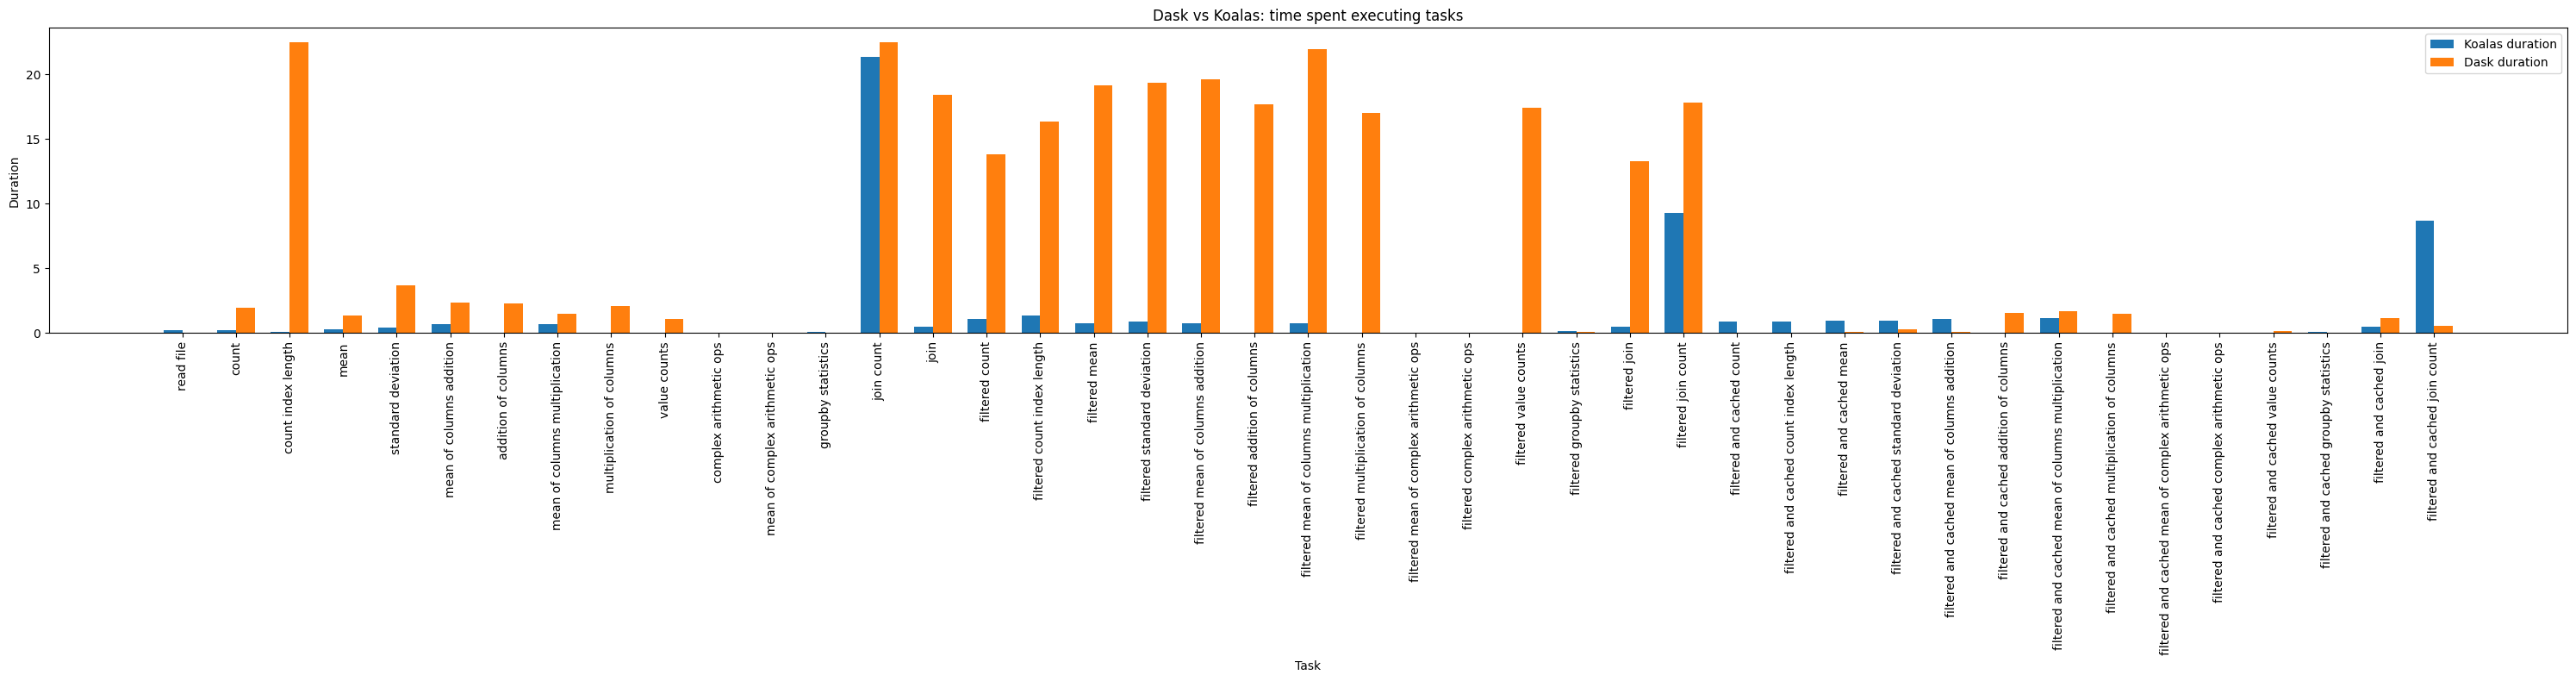

In [68]:
# keys = range(1,len(koalas_benchmarks['task'])+1)
keys = koalas_benchmarks['task']
koalas_values = koalas_benchmarks['duration']
dask_values = dask_benchmarks['duration']

x = np.arange(len(keys))
width = 0.35

fig, ax = plt.subplots(figsize=(30,8))

koalas_bar = ax.bar(x-width/2,koalas_values,width,label='Koalas duration')
dask_bar = ax.bar(x+width/2,dask_values,width,label='Dask duration')

ax.set_xlabel('Task')
ax.set_ylabel('Duration')
ax.set_title('Dask vs Koalas: time spent executing tasks')
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

###### Note: The plots were delivered as 'png' files for better visualization if needed. 

The results of this experiment allow us to conclude that Koalas[pyspark] is generally significantly faster than Dask on various database-like operations.

## EXPERIMENT 2: Running datasets with different combinations

### Dask + Modin

In [ ]:
import modin.pandas as mpd
from modin.config import Engine

print('modin version: %s' % mpd.__version__)

Engine.put("dask")

In [ ]:
dask_modin_data = mpd.read_parquet(paths[0])

In [ ]:
dask_modin_benchmarks = {
    'duration': [],     # in seconds
    'task': []
}

#### Standard Operations

In [ ]:
def read_file_parquet(df=None):
    return mpd.read_parquet("../yellow_tripdata_2011-01.parquet")

def count(df=None):
    return len(df)

def count_index_length(df=None):
    return len(df.index)

def mean(df):
    return df.fare_amount.mean()

def standard_deviation(df):
    return df.fare_amount.std()

def mean_of_sum(df):
    return (df.fare_amount + df.tip_amount).mean()

def sum_columns(df):
    x = df.fare_amount + df.tip_amount
    return x

def mean_of_product(df):
    return (df.fare_amount * df.tip_amount).mean()

def product_columns(df):
    x = df.fare_amount * df.tip_amount
    return x

def value_counts(df):
    val_counts = df.fare_amount.value_counts()
    return val_counts


#   In the original experiment, the following two functions used the longitude and latitude values of the pickup and the dropout places.
#   Since the datasets provided by NYC TLC Trip Record Data no longer have longitude and latitude values (only the pickup and dropout places IDs),
# we used arbitrary longitude and latitude values. The goal of this experiment is to compare the computational cost of the calculations, hence
# the values are not relevant.
def complicated_arithmetic_operation(df):
    start_lon,end_lon = np.random.randint(-180,180),np.random.randint(-180,180)
    start_lat,end_lat = np.random.randint(-90,90),np.random.randint(-90,90)
    
    theta_1 = start_lon
    phi_1 = start_lat
    theta_2 = end_lon
    phi_2 = end_lat
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180) * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = np.multiply(np.arctan2(np.sqrt(temp), np.sqrt(1-temp)),2)
    return ret

def mean_of_complicated_arithmetic_operation(df):
    start_lon,end_lon = np.random.randint(-180,180),np.random.randint(-180,180)
    start_lat,end_lat = np.random.randint(-90,90),np.random.randint(-90,90)
    
    theta_1 = start_lon
    phi_1 = start_lat
    theta_2 = end_lon
    phi_2 = end_lat
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180) * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = np.multiply(np.arctan2(np.sqrt(temp), np.sqrt(1-temp)),2) 
    return ret.mean()

def groupby_statistics(df):
    gb = df.groupby(by='passenger_count').agg(
      {
        'fare_amount': ['mean', 'std'], 
        'tip_amount': ['mean', 'std']
      }
    )
    return gb

other = groupby_statistics(dask_modin_data)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

def join_count(df, other):
    return len(mpd.merge(df, other, left_index=True, right_index=True))

def join_data(df, other):
    return mpd.merge(df, other, left_index=True, right_index=True)

In [ ]:
benchmark(read_file_parquet, df=None, benchmarks=dask_modin_benchmarks, name='read file')
benchmark(count, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='count')
benchmark(count_index_length, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='count index length')
benchmark(mean, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='mean')
benchmark(standard_deviation, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='standard deviation')
benchmark(mean_of_sum, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='mean of columns addition')
benchmark(sum_columns, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='addition of columns')
benchmark(mean_of_product, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='mean of columns multiplication')
benchmark(product_columns, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='multiplication of columns')
benchmark(value_counts, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='value counts')
benchmark(mean_of_complicated_arithmetic_operation, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='complex arithmetic ops')
benchmark(groupby_statistics, df=dask_modin_data, benchmarks=dask_modin_benchmarks, name='groupby statistics')
benchmark(join_count, dask_modin_data, benchmarks=dask_modin_benchmarks, name='join count', other=other)
benchmark(join_data, dask_modin_data, benchmarks=dask_modin_benchmarks, name='join', other=other)

#### Operations with filtering

In [ ]:
expr_filter = (dask_modin_data.tip_amount >= 1) & (dask_modin_data.tip_amount <= 5)

def filter_data(df):
    return df[expr_filter]

dask_modin_filtered = filter_data(dask_modin_data)

In [ ]:
benchmark(count, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered count')
benchmark(count_index_length, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered count index length')
benchmark(mean, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered mean')
benchmark(standard_deviation, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered standard deviation')
benchmark(mean_of_sum, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name ='filtered mean of columns addition')
benchmark(sum_columns, df=dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered addition of columns')
benchmark(mean_of_product, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name ='filtered mean of columns multiplication')
benchmark(product_columns, df=dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered complex arithmetic ops')
benchmark(value_counts, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name ='filtered value counts')
benchmark(groupby_statistics, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered groupby statistics')

other = groupby_statistics(dask_modin_filtered)
other.columns = pd.Index([e[0] +'_'+ e[1] for e in other.columns.tolist()])

benchmark(join_count, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered join count', other=other)
benchmark(join_data, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered join', other=other)

NameError: name 'dask_filtered' is not defined

#### Operations with filtering and caching

In [ ]:
dask_modin_filtered = client.persist(dask_modin_filtered)

from distributed import wait
print('Waiting until all futures are finished')
wait(dask_modin_filtered)
print('All futures are finished')

In [ ]:
benchmark(count, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered count')
benchmark(count_index_length, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered count index length')
benchmark(mean, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered mean')
benchmark(standard_deviation, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered standard deviation')
benchmark(mean_of_sum, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name ='filtered mean of columns addition')
benchmark(sum_columns, df=dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered addition of columns')
benchmark(mean_of_product, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name ='filtered mean of columns multiplication')
benchmark(product_columns, df=dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered complex arithmetic ops')
benchmark(value_counts, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name ='filtered value counts')
benchmark(groupby_statistics, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered groupby statistics')

other = groupby_statistics(dask_modin_filtered)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

benchmark(join_count, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered join count', other=other)
benchmark(join_data, dask_modin_filtered, benchmarks=dask_modin_benchmarks, name='filtered join', other=other)

NameError: name 'dask_filtered' is not defined

In [ ]:
client.restart()

NameError: name 'client' is not defined

## Conclusions